In [1]:
# !pip install torch_geometric torch scipy


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
print(data)

Data(x=[3, 1], edge_index=[2, 4])


In [3]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='./data/Cora', name='Cora')
data = dataset[0]  # Access the graph data


In [4]:
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


## Step-by-Step Flow with Calculations

1. **First Layer: `GCNConv(1433, 4)`**

  - **Input Transformation:** The input $X \in \mathbb{R}^{5 \times 1433}$ is multiplied by a weight matrix $W^{(0)} \in \mathbb{R}^{1433 \times 4}$.
    \[
    XW^{(0)} \Rightarrow H^{(1)} \in \mathbb{R}^{5 \times 4}
    \]

  - **Neighborhood Aggregation:** Each node’s new features (in $H^{(1)}$) are updated by aggregating its neighbors' features. This is done by the normalized adjacency matrix $\tilde{D}^{-1/2} \tilde{A} \tilde{D}^{-1/2}$, effectively averaging each node's features with its neighbors.

  - **Nonlinear Activation:** After the aggregation, a non-linear activation (like ReLU) is applied, helping introduce non-linearity to the model.

  This results in the output shape of $H^{(1)} \in \mathbb{R}^{5 \times 4}$, where each node now has 4 features after the first layer.

2. **Second Layer: `GCNConv(4, 2)`**

  - **Input Transformation:** We take the output $H^{(1)}$ from the first layer and transform it using a new weight matrix $W^{(1)} \in \mathbb{R}^{4 \times 2}$.
    \[
    H^{(1)}W^{(1)} \Rightarrow H^{(2)} \in \mathbb{R}^{5 \times 2}
    \]

  - **Neighborhood Aggregation:** Like in the first layer, we use the normalized adjacency matrix to average each node’s features with its neighbors'.

  - **Nonlinear Activation:** Applying a non-linear activation (e.g., ReLU) to the aggregated features gives the final output for this layer.

  After this layer, we have an output shape of $H^{(2)} \in \mathbb{R}^{5 \times 2}$, meaning each node now has a 2-dimensional representation.

**Final Flow Summary**

Through these two `GCNConv` layers:

- The first layer reduces the dimensionality from 1433 to 4 features per node.
- The second layer reduces the dimensionality further from 4 to 2 features per node.

The GCN layers’ operations result in each node embedding information about itself and its neighbors, which is essential for learning graph-structured data. These node embeddings (2-dimensional) can now be used for tasks like classification or clustering.


In [12]:
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# Define a simple GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(1433, 4)  # Adjust input dimension to 1433
        self.conv2 = GCNConv(4, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        print('forward', x.shape)
        return F.log_softmax(x, dim=1)

# Initialize the model, optimizer, and loss function
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Dummy labels for the nodes (assuming 2708 nodes)
labels = torch.randint(0, 2, (2708,), dtype=torch.long)

# Training loop
model.train()
for epoch in range(20):
    optimizer.zero_grad()
    out = model(dataset)
    loss = criterion(out, labels)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluation
model.eval()
_, pred = model(data).max(dim=1)
correct = (pred == labels).sum().item()
accuracy = correct / len(labels)
print(f'Accuracy: {accuracy:.4f}')

forward torch.Size([2708, 2])
Epoch 1, Loss: 0.6942176818847656
forward torch.Size([2708, 2])
Epoch 2, Loss: 0.6902497410774231
forward torch.Size([2708, 2])
Epoch 3, Loss: 0.6882117390632629
forward torch.Size([2708, 2])
Epoch 4, Loss: 0.6845946907997131
forward torch.Size([2708, 2])
Epoch 5, Loss: 0.6801221370697021
forward torch.Size([2708, 2])
Epoch 6, Loss: 0.6755695343017578
forward torch.Size([2708, 2])
Epoch 7, Loss: 0.6710864305496216
forward torch.Size([2708, 2])
Epoch 8, Loss: 0.6663144826889038
forward torch.Size([2708, 2])
Epoch 9, Loss: 0.6603422164916992
forward torch.Size([2708, 2])
Epoch 10, Loss: 0.6549365520477295
forward torch.Size([2708, 2])
Epoch 11, Loss: 0.650624692440033
forward torch.Size([2708, 2])
Epoch 12, Loss: 0.6456233263015747
forward torch.Size([2708, 2])
Epoch 13, Loss: 0.6403387784957886
forward torch.Size([2708, 2])
Epoch 14, Loss: 0.6358634829521179
forward torch.Size([2708, 2])
Epoch 15, Loss: 0.6311662793159485
forward torch.Size([2708, 2])
Epoch

In [13]:
from torch_geometric.utils import to_networkx
G = to_networkx(data, to_undirected=True)

In [11]:
# !pip install --upgrade pip
# !pip install matplotlib

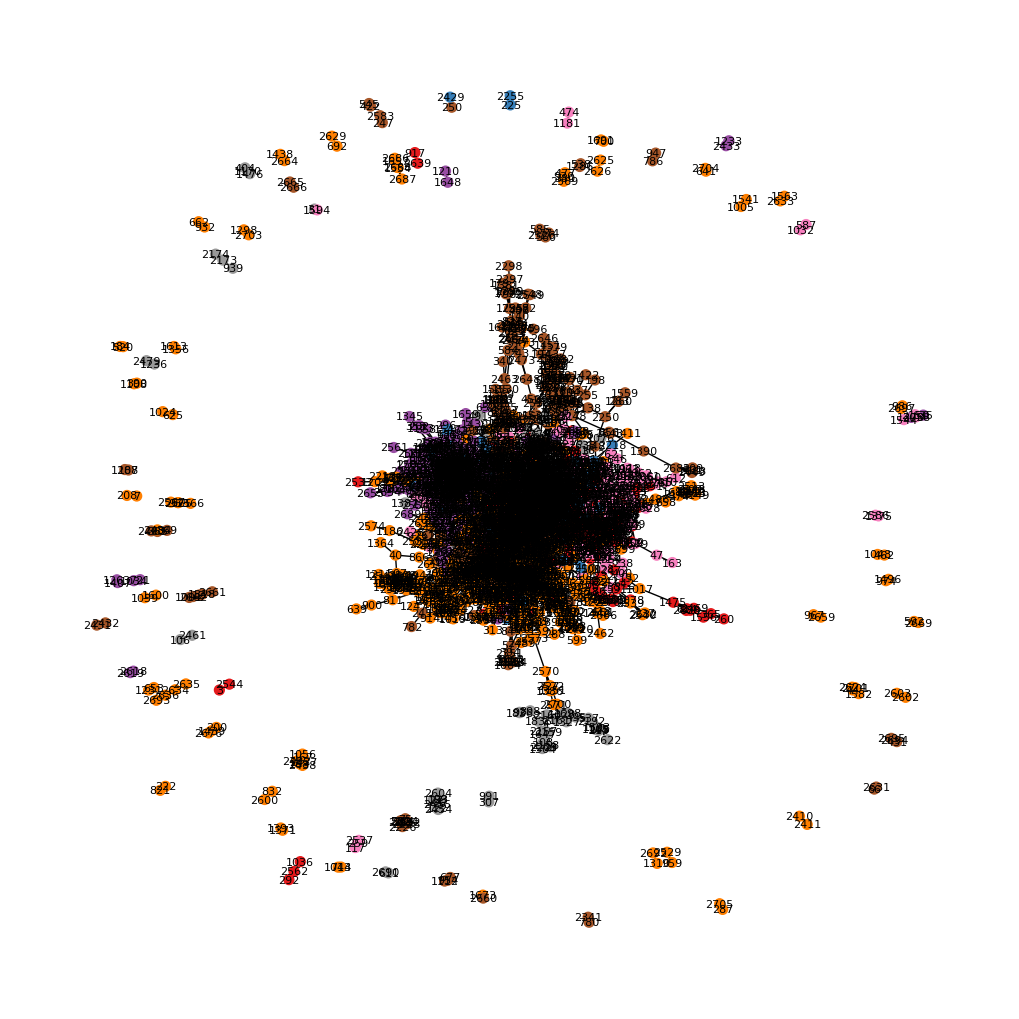

In [14]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_color=data.y, cmap=plt.get_cmap('Set1'), node_size=50, font_size=8)
plt.show()